In [15]:
!pip install geocoder
!pip install folium

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 98 kB 6.0 MB/s  eta 0:00:01
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |██████████████████████████

In [94]:
from bs4 import BeautifulSoup
import requests
import csv
import pandas as pd
import json
import geocoder
from pandas.io.json import json_normalize
import numpy as np
# import k-means from clustering stage
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

## Scrap the data from the website

In [2]:
# send the GET request
data = requests.get('https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago').text

In [7]:
soup = BeautifulSoup(data, 'lxml')

In [12]:
neighborhoodList = []
communityList = []
for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')
    if(len(cells) > 0):
              neighborhoodList.append(cells[0].text.rstrip('\n'))
              communityList.append(cells[1].text.rstrip('\n'))
# create a new DataFrame from the three lists
chicago_df = pd.DataFrame({
                           "Neighborhood": neighborhoodList,
                           "Community":communityList})

chicago_df.head()

,Neighborhood,Community
0,Albany Park,Albany Park
1,Altgeld Gardens,Riverdale
2,Andersonville,Edgewater
3,Archer Heights,Archer Heights
4,Armour Square,Armour Square


## Get the lattitude and longitude coordinates

In [18]:
# Defining a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Chicago, United States'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords
# Call the function to get the coordinates, store in a new list using list comprehension
coords = [ get_latlng(neighborhood) for neighborhood in chicago_df["Neighborhood"].tolist()]

In [19]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
# Merge the coordinates into the original dataframe
chicago_df['Latitude'] = df_coords['Latitude']
chicago_df['Longitude'] = df_coords['Longitude']
print(chicago_df.shape)
chicago_df

(246, 4)


,Neighborhood,Community,Latitude,Longitude
0,Albany Park,Albany Park,41.968290,-87.72338
1,Altgeld Gardens,Riverdale,41.654480,-87.60225
2,Andersonville,Edgewater,41.980460,-87.66834
3,Archer Heights,Archer Heights,41.811540,-87.72556
4,Armour Square,Armour Square,41.834580,-87.63189
...,...,...,...,...
241,Wildwood,Forest Glen,42.001350,-87.77537
242,Woodlawn,Woodlawn,41.780460,-87.60135
243,Wrightwood,Ashburn,41.928979,-87.65619
244,Wrightwood Neighbors,Lincoln Park,41.928979,-87.65619


In [24]:
address = 'Chicago, United States'
geolocator = Nominatim(user_agent="chicago_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Chicago, United States {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Chicago, United States 41.8755616, -87.6244212.


## Visualize map

In [31]:
# create map of New York using latitude and longitude values
map_Chicago = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng,  neighborhood in zip(chicago_df['Latitude'], chicago_df['Longitude'],  chicago_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Chicago)  
    
map_Chicago

In [32]:

CLIENT_ID = 'ITLTYDW11CFXRNWCPOA0VMPMWBUOR04EZVX3YRXTGXHXU2PY' # your Foursquare ID
CLIENT_SECRET = 'Q5RHQROS31TVELN0ZX45LG3TJPMLLE2ATDJ0YC2BABXSBYSK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ITLTYDW11CFXRNWCPOA0VMPMWBUOR04EZVX3YRXTGXHXU2PY
CLIENT_SECRET:Q5RHQROS31TVELN0ZX45LG3TJPMLLE2ATDJ0YC2BABXSBYSK


In [34]:
radius = 2000
venues = []
for lat, long, neighborhood in zip(chicago_df['Latitude'], chicago_df['Longitude'], chicago_df['Neighborhood']):
# Create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(CLIENT_ID,CLIENT_SECRET,VERSION,lat,long,radius,LIMIT)
# Make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
# Return only relevant information for each nearby venue
    for venue in results:
        venues.append((neighborhood,lat,long,venue['venue']['name'],
        venue['venue']['location']['lat'],venue['venue']['location']    ['lng'],venue['venue']['categories'][0]['name']))

In [36]:
venues_df = pd.DataFrame(venues)
# Defining the column names
venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']
print(venues_df.shape)
venues_df.head()

(20933, 7)


,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Albany Park,41.96829,-87.72338,Lawrence Fish Market,41.968280,-87.726250,Seafood Restaurant
1,Albany Park,41.96829,-87.72338,Starbucks,41.968911,-87.728817,Coffee Shop
2,Albany Park,41.96829,-87.72338,Chicago Kalbi Korean BBQ,41.968314,-87.722771,Korean Restaurant
3,Albany Park,41.96829,-87.72338,Nighthawk,41.967974,-87.713415,Cocktail Bar
4,Albany Park,41.96829,-87.72338,Ssyal Korean Restaurant and Ginseng House,41.968172,-87.733207,Korean Restaurant
...,...,...,...,...,...,...,...
195,Andersonville,41.98046,-87.66834,Yes Thai,41.976426,-87.679517,Thai Restaurant
196,Andersonville,41.98046,-87.66834,First Sip,41.973270,-87.657245,Coffee Shop
197,Andersonville,41.98046,-87.66834,Pho Viet,41.972801,-87.659538,Vietnamese Restaurant
198,Andersonville,41.98046,-87.66834,Whole Foods Market,41.991463,-87.659924,Grocery Store


In [56]:
# Lets check how many venues were returned for each neighbourhood
venues_df.groupby(["Neighborhood"]).count()
# Lets check out how many unique categories can be curated from all the returned values
print('There are {} unique categories.'.format(len(venues_df['VenueCategory'].unique())))

# Displaying the first unique 100 Venue Category names
venues_df['VenueCategory'].unique()[:100]


There are 408 unique categories.


array(['Seafood Restaurant', 'Coffee Shop', 'Korean Restaurant',
       'Cocktail Bar', 'Park', 'Chinese Restaurant', 'Pizza Place',
       'Middle Eastern Restaurant', 'Hookah Bar',
       'Scandinavian Restaurant', 'Diner', 'Afghan Restaurant',
       'Discount Store', 'Café', 'Vietnamese Restaurant', 'Karaoke Bar',
       'Mexican Restaurant', 'Hot Dog Joint', 'Ice Cream Shop',
       'Grocery Store', 'Brazilian Restaurant', 'Fish Market',
       'American Restaurant', 'Taco Place', 'Fried Chicken Joint',
       'Restaurant', 'Dive Bar', 'Persian Restaurant',
       'South American Restaurant', 'Latin American Restaurant',
       'Brewery', 'Bar', 'Nail Salon', 'Pet Store', 'Bakery',
       'Breakfast Spot', 'Shipping Store', 'Cuban Restaurant',
       'Dessert Shop', 'Donut Shop', 'Thrift / Vintage Store',
       'Sushi Restaurant', 'Sandwich Place', 'Supermarket',
       'Mobile Phone Shop', 'Recording Studio', 'Asian Restaurant',
       'Moroccan Restaurant', 'Gift Shop', 'Pie Sh

In [38]:

venues_df.groupby('Neighborhood').count().head()

,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
Neighborhood,,,,,,
Albany Park,100,100,100,100,100,100
Altgeld Gardens,17,17,17,17,17,17
Andersonville,100,100,100,100,100,100
Archer Heights,100,100,100,100,100,100
Armour Square,100,100,100,100,100,100


In [40]:
# one hot encoding
Chicago_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Chicago_onehot['Neighborhood'] = venues_df['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Chicago_onehot.columns[-1]] + list(Chicago_onehot.columns[:-1])
Chicago_onehot = Chicago_onehot[fixed_columns]
Chicago_grouped = Chicago_onehot.groupby('Neighborhood').mean().reset_index()
Chicago_onehot.head(5)

,Zoo Exhibit,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Getting Indian restaurants

In [57]:
len((Chicago_grouped[Chicago_grouped["Indian Restaurant"] > 0]))

29

In [60]:
# Creating a dataframe for Shopping Mall data only
chicago_restaurants = Chicago_grouped[["Neighborhood","Indian Restaurant"]]

## Identify the number of clusters

In [89]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = chicago_restaurants.drop(['Neighborhood'], axis=1)

In [90]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32)

In [91]:

def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [92]:
scores = [get_inertia(x) for x in range(2, 21)]

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  app.launch_new_instance()
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  app.launch_new_instance()
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  app.launch_new_instance()
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  app.launch_new_instance()
/opt/conda/envs/Python-3.7-main/lib/

Text(0, 0.5, 'Error')

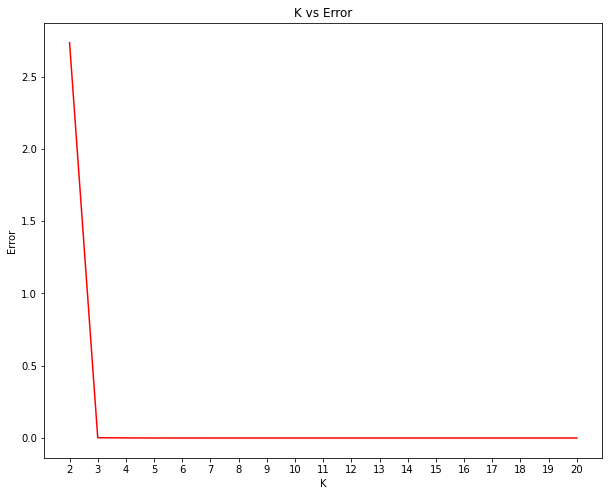

In [95]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

## Create Clusters

In [63]:
# Setting the number of clusters
kclusters = 3
chicago_clustering = chicago_restaurants.drop(["Neighborhood"], 1)
# Run k-means clustering algorithm
kmeans = KMeans(n_clusters=kclusters,random_state=0).fit(chicago_clustering)
# Checking cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 2], dtype=int32)

In [64]:
# Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
chicago_merged = chicago_restaurants.copy()
# Add the clustering labels
chicago_merged["Cluster Labels"] = kmeans.labels_


,Neighborhood,Indian Restaurant,Cluster Labels
0,Albany Park,0.00,0
1,Altgeld Gardens,0.00,0
2,Andersonville,0.00,0
3,Archer Heights,0.00,0
4,Armour Square,0.00,0
5,Ashburn,0.00,0
6,Ashburn Estates,0.00,0
7,Auburn Gresham,0.00,0
8,Avalon Park,0.00,0
9,Avondale,0.01,2


In [65]:

 # Adding latitude and longitude values to the existing dataframe
chicago_merged['Latitude'] = chicago_df['Latitude']
chicago_merged['Longitude'] = chicago_df['Longitude']
# Sorting the results by Cluster Labels
chicago_merged.sort_values(["Cluster Labels"], inplace=True)
chicago_merged

,Neighborhood,Indian Restaurant,Cluster Labels,Latitude,Longitude
0,Albany Park,0.00,0,41.968290,-87.723380
146,Norwood Park East,0.00,0,41.909030,-87.719224
147,Norwood Park West,0.00,0,41.967930,-87.737880
148,O'Hare,0.00,0,41.982940,-87.719150
149,Oakland,0.00,0,41.884250,-87.632450
...,...,...,...,...,...
87,Hollywood Park,0.05,2,41.653680,-87.546220
211,Tri-Taylor,0.01,2,39.808120,-75.512510
137,Noble Square,0.02,2,41.900340,-87.634330
191,Sheridan Station Corridor,0.01,2,41.963399,-87.845134


In [69]:
# Creating the map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
# Setting color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_merged['Latitude'], chicago_merged['Longitude'], chicago_merged['Neighborhood'], chicago_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat,lon],radius=5,popup=label,color=rainbow[cluster-1],fill=True,fill_color=rainbow[cluster-1],fill_opacity=0.7).add_to(map_clusters)
map_clusters

In [79]:
chicago_restaurants["Cluster Labels"] = kmeans.labels_
chicago_restaurants.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Neighborhood,Indian Restaurant,Cluster Labels
0,Albany Park,0.0,0
1,Altgeld Gardens,0.0,0
2,Andersonville,0.0,0
3,Archer Heights,0.0,0
4,Armour Square,0.0,0


## Examine clusters

In [72]:
len(chicago_merged.loc[chicago_merged['Cluster Labels'] == 0])


215

In [73]:
len(chicago_merged.loc[chicago_merged['Cluster Labels'] == 1])


3

In [74]:
len(chicago_merged.loc[chicago_merged['Cluster Labels'] == 2])

26

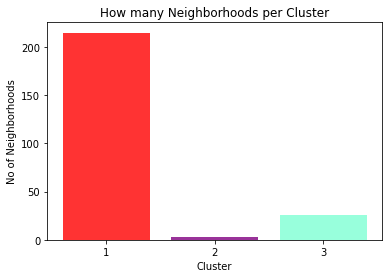

In [83]:

objects = (1,2,3)
y_pos = np.arange(len(objects))
performance = chicago_restaurants['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

In [85]:
cluster1 = chicago_merged.loc[chicago_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(chicago_df, cluster1, on='Neighborhood')
df_cluster1

,Neighborhood,Community,Latitude_x,Longitude_x,Indian Restaurant,Cluster Labels,Latitude_y,Longitude_y
0,Albany Park,Albany Park,41.968290,-87.72338,0.0,0,41.968290,-87.723380
1,Altgeld Gardens,Riverdale,41.654480,-87.60225,0.0,0,41.654480,-87.602250
2,Andersonville,Edgewater,41.980460,-87.66834,0.0,0,41.980460,-87.668340
3,Archer Heights,Archer Heights,41.811540,-87.72556,0.0,0,41.811540,-87.725560
4,Armour Square,Armour Square,41.834580,-87.63189,0.0,0,41.834580,-87.631890
...,...,...,...,...,...,...,...,...
210,Wildwood,Forest Glen,42.001350,-87.77537,0.0,0,41.762390,-87.595761
211,Woodlawn,Woodlawn,41.780460,-87.60135,0.0,0,41.910360,-87.682960
212,Wrightwood,Ashburn,41.928979,-87.65619,0.0,0,42.001350,-87.775370
213,Wrightwood Neighbors,Lincoln Park,41.928979,-87.65619,0.0,0,41.780460,-87.601350


In [87]:
cluster2 = chicago_merged.loc[chicago_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(chicago_df, cluster2, on='Neighborhood')
df_cluster2

,Neighborhood,Community,Latitude_x,Longitude_x,Indian Restaurant,Cluster Labels,Latitude_y,Longitude_y
0,Eden Green,Riverdale,42.011757,-87.699985,0.12,1,41.899640,-87.672430
1,West Ridge,West Ridge,41.999480,-87.692660,0.15,1,41.667419,-87.646462
2,West Rogers Park,West Ridge,41.997680,-87.694140,0.15,1,41.679510,-87.641890


In [88]:
cluster3 = chicago_merged.loc[chicago_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(chicago_df, cluster3, on='Neighborhood')
df_cluster3

,Neighborhood,Community,Latitude_x,Longitude_x,Indian Restaurant,Cluster Labels,Latitude_y,Longitude_y
0,Avondale,Avondale,41.939250,-87.711250,0.010000,2,41.939250,-87.711250
1,Edgebrook,Forest Glen,41.997320,-87.764230,0.010000,2,42.011757,-87.699985
2,Forest Glen,Forest Glen,41.976400,-87.753610,0.010000,2,41.753151,-87.732240
3,The Gap,Douglas,41.931593,-87.712179,0.010000,2,41.761580,-87.578020
4,Goose Island,Near North Side,41.903285,-87.653001,0.010000,2,41.903950,-87.628860
5,Gresham,Auburn Gresham,41.935956,-87.714608,0.010000,2,41.762060,-87.614580
6,Hollywood Park,North Park,41.989300,-87.710730,0.050000,2,41.653680,-87.546220
7,Illinois Medical District,Near West Side,41.863506,-87.680931,0.010000,2,41.899070,-87.719470
8,Kosciuszko Park,Logan Square,41.930040,-87.724530,0.010000,2,41.681090,-87.607000
9,Legends South (Robert Taylor Homes),Grand Boulevard,31.226166,-85.418333,0.016949,2,41.885760,-87.624310
